<a href="https://colab.research.google.com/github/Ansuman09/cv/blob/main/Part2_TemperatureTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is a notebook on temperature time series to try to predict the recent max temperature

In [3]:
import pandas as pd
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

This data was obtained from GHCND and is the same one that was used in temperature analysis.


Let's read the data

In [4]:
weather_data=pd.read_csv('USW00094728.csv')
weather_data.columns=['ID','DATE','ELEMENT','VALUE1','MFLAG1','LATITUDE','SFLAG1','LONGITUDE']
weather_data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ID,DATE,ELEMENT,VALUE1,MFLAG1,LATITUDE,SFLAG1,LONGITUDE
0,USW00094728,18690102,TMAX,-28,NaN,NaN,Z,NaN
1,USW00094728,18690103,TMAX,17,NaN,NaN,Z,NaN
2,USW00094728,18690104,TMAX,28,NaN,NaN,Z,NaN
3,USW00094728,18690105,TMAX,61,NaN,NaN,Z,NaN
4,USW00094728,18690106,TMAX,33,NaN,NaN,Z,NaN


select the data from 2010 because the temprature data is more frequently recorded since then.

In [5]:
new_df=weather_data[(weather_data['DATE'] > 20100100) & (weather_data['ELEMENT']=='TMAX')]
new_df.head()

,ID,DATE,ELEMENT,VALUE1,MFLAG1,LATITUDE,SFLAG1,LONGITUDE
334502,USW00094728,20101201,TMAX,156,NaN,NaN,0,2400.0
334503,USW00094728,20101202,TMAX,56,NaN,NaN,0,2400.0
334504,USW00094728,20101203,TMAX,44,NaN,NaN,0,2400.0
334505,USW00094728,20101204,TMAX,44,NaN,NaN,0,2400.0
334506,USW00094728,20101205,TMAX,17,NaN,NaN,0,2400.0


In [6]:
new_df=new_df[['VALUE1','DATE']]
new_df=new_df.dropna()

In [7]:
new_df.set_index('DATE',inplace=True)
new_df.sort_index(inplace=True)

Let's visualise the temperature changes

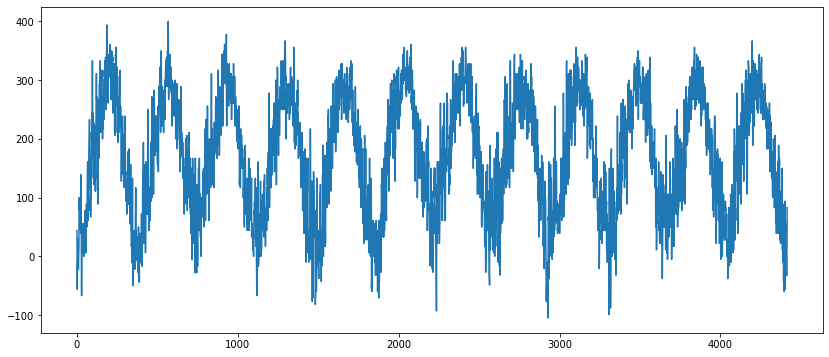

In [8]:
new_df.reset_index(inplace=True)
plt.figure(figsize=(14,6))
plt.plot(new_df['VALUE1'])

In [9]:
print(f'total number of days on which the data has been recorded : {new_df.shape[0]}')

total number of days on which the data has been recorded : 4416


In [10]:
#creating the base series and time 
series=new_df['VALUE1'].to_numpy()
time_series=new_df.index

## First let's predict the time series prediction using a moving average

In [11]:
def moving_average(series,window_size):
  forecast=[]

  for time in range(len(series)-window_size):
    forecast.append(series[time:time+window_size].mean())
  
  forecast=np.array(forecast)
  return forecast

In [12]:
splitter=4000
X_train=series[:splitter]
y_train=time_series[:splitter]

X_test=series[splitter:]
y_test=time_series[splitter:]

In [13]:
window_size=7
forecast_series = series
prediction_mvn=moving_average(forecast_series,7)[splitter-window_size:]

print(f'forecast series shape:{prediction_mvn.shape}     test series shape: {X_test.shape}')

forecast series shape:(416,)     test series shape: (416,)


In [14]:
print(tf.keras.metrics.mean_squared_error(X_test, prediction_mvn).numpy())

2222.844338697017


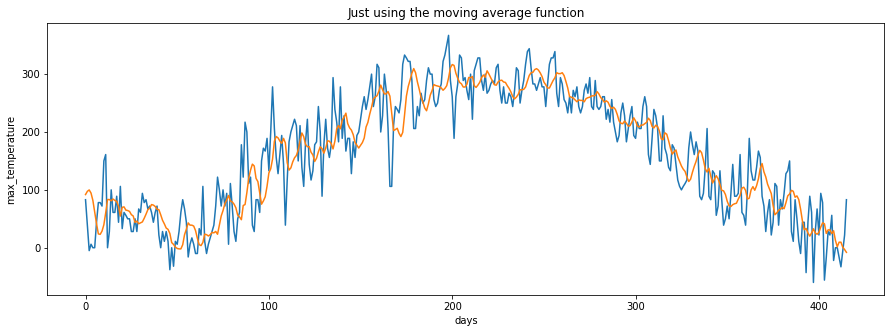

In [15]:
plt.figure(figsize=(15,5))
plt.plot(X_test)
plt.plot(prediction_mvn)
plt.title('Just using the moving average function')
plt.xlabel('days')
plt.ylabel('max_temperature');

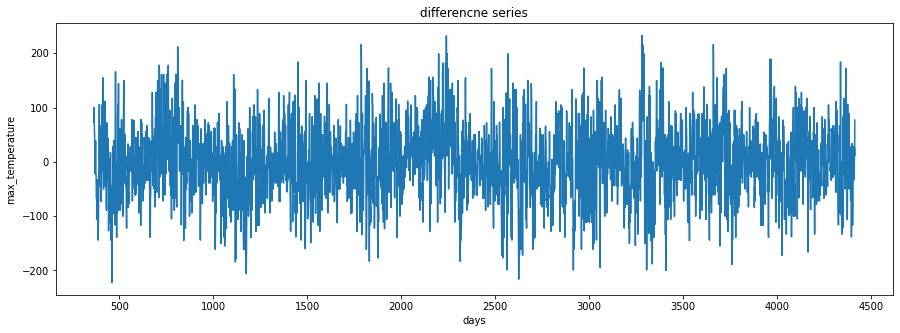

In [16]:
#difference
diff_series=series[365:]-series[:-365]
diff_time=time_series[365:]

plt.figure(figsize=(15,5))
plt.title('differencne series')
plt.xlabel('days')
plt.ylabel('max_temperature')
plt.plot(diff_time,diff_series);

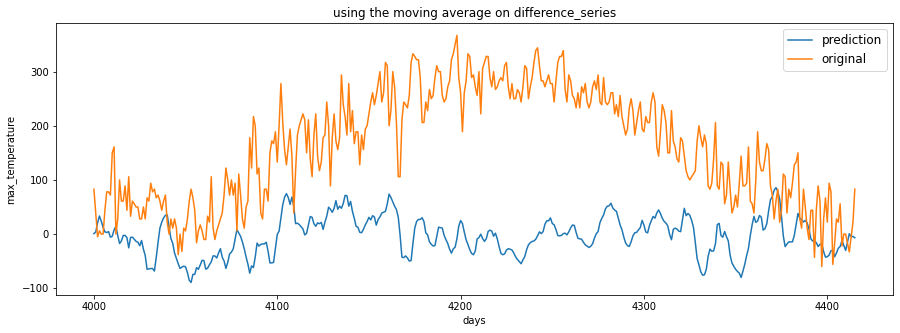

In [18]:
diff_mvn_avg=moving_average(diff_series,7)[splitter-365-7:] #this so that we can start from the same place as we did when
diff_mvn_time=diff_time[splitter-365:]                      #we used the splitter that is by taking 365 steps back

plt.figure(figsize=(15,5))
plt.title('using the moving average on difference_series')
plt.xlabel('days')
plt.ylabel('max_temperature');
plt.plot(y_test,diff_mvn_avg,label='prediction')
plt.plot(y_test,X_test,label='original')
plt.legend(fontsize=12);

## Final Moving average prediction using difference series 

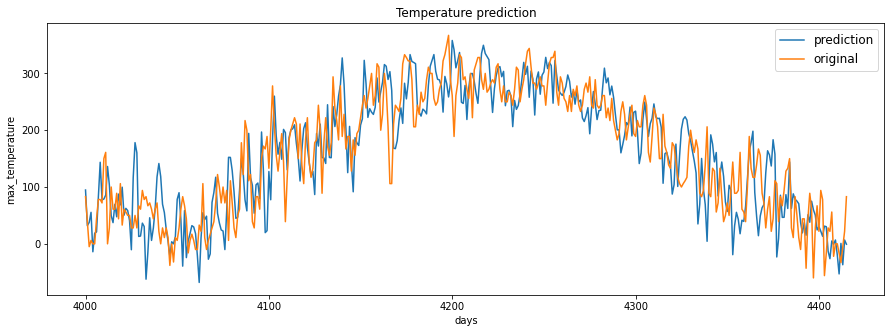

In [19]:
diff_moving_avg_plus_past = series[splitter - 365:-365] + diff_mvn_avg

plt.figure(figsize=(15,5))
plt.title('Temperature prediction')
plt.xlabel('days')
plt.ylabel('max_temperature');
plt.plot(y_test,diff_moving_avg_plus_past,label='prediction')
plt.plot(y_test,X_test,label='original')
plt.legend(fontsize=12);

In [20]:
print(f'mse: {tf.keras.metrics.mean_squared_error(X_test, diff_moving_avg_plus_past).numpy()}')
print(f'mae: {tf.keras.metrics.mean_absolute_error(X_test, diff_moving_avg_plus_past).numpy()}')

mse: 3479.967229199372
mae: 45.09409340659341


## Creating the function that would return a tf dataset element for predicting the time series using a NeuralNet


In [21]:
def create_tf_data(series,window_size,batch_size,shuffle_buffer):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda window : window.batch(window_size+1))
  dataset=dataset.map(lambda window : (window[:-1],window[-1]))
  dataset=dataset.shuffle(shuffle_buffer)
  dataset=dataset.batch(batch_size).prefetch(1)
  return dataset

## Understanding the fuction with an Example

### This is how the dataset will look like if passed though the create_tf_dataset function the previous values in th window '4' will represent the features while the 5th element in the row here will represent the label

In [22]:
dataset=create_tf_data([1,2,3,4,5,6,7,8,9,110,11,12,13,14],4,1,1)

for data in dataset:
  for n in data:
    print(n.numpy(),end=' ')
  print('')

[[1 2 3 4]] [5] 
[[2 3 4 5]] [6] 
[[3 4 5 6]] [7] 
[[4 5 6 7]] [8] 
[[5 6 7 8]] [9] 
[[6 7 8 9]] [110] 
[[  7   8   9 110]] [11] 
[[  8   9 110  11]] [12] 
[[  9 110  11  12]] [13] 
[[110  11  12  13]] [14] 


Now we set the parameters and train the model choosing the appropriate learing rate 

In [23]:
window_size=7
shuffle_buffer=1000
batch_size=8

train_set=create_tf_data(X_train,window_size,batch_size,shuffle_buffer)

# Model


In [24]:
model=keras.models.Sequential([
                               keras.layers.Dense(7,input_shape=[window_size],activation='relu'),
                               keras.layers.Dense(3,activation='relu'),
                               keras.layers.Dense(1)
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 dense_1 (Dense)             (None, 3)                 24        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


In [25]:
init_weights = model.get_weights()
init_weights

[array([[-0.06572801, -0.35813516,  0.15211743, -0.12820107, -0.3062494 ,
         -0.00459677, -0.21769246],
        [ 0.10820544, -0.30477712, -0.05216324, -0.4535455 ,  0.1990574 ,
         -0.41124505, -0.62995017],
        [-0.53355044,  0.12786484, -0.6068037 ,  0.19683999,  0.00547582,
         -0.04683214, -0.07741165],
        [ 0.39291048,  0.12250316,  0.07917786, -0.00309616, -0.6308345 ,
          0.39492464,  0.40818894],
        [ 0.3544507 , -0.48806918,  0.5627872 , -0.08515906,  0.15903121,
         -0.470724  ,  0.38408577],
        [-0.10752183,  0.21164823,  0.47243154,  0.0481267 ,  0.4713062 ,
         -0.32838756,  0.5466361 ],
        [ 0.4386971 , -0.31365862, -0.5610737 , -0.518745  , -0.24309021,
         -0.13693446, -0.29794183]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([[ 0.5950819 , -0.68658257, -0.15335906],
        [-0.4548413 ,  0.0900386 , -0.0905444 ],
        [ 0.00592709, -0.6720923 ,  0.68444896],
        [-0.0

In [ ]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))

optimizer=tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=keras.losses.Huber(),optimizer=optimizer)
history=model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
500/500 [==============================] - 3s 5ms/step - loss: 163.6353 - lr: 1.0000e-08
Epoch 2/100
500/500 [==============================] - 2s 5ms/step - loss: 163.0180 - lr: 1.1220e-08
Epoch 3/100
500/500 [==============================] - 2s 5ms/step - loss: 162.3066 - lr: 1.2589e-08
Epoch 4/100
500/500 [==============================] - 2s 5ms/step - loss: 161.4834 - lr: 1.4125e-08
Epoch 5/100
500/500 [==============================] - 2s 5ms/step - loss: 160.5283 - lr: 1.5849e-08
Epoch 6/100
500/500 [==============================] - 3s 5ms/step - loss: 159.4063 - lr: 1.7783e-08
Epoch 7/100
500/500 [==============================] - 2s 5ms/step - loss: 158.0791 - lr: 1.9953e-08
Epoch 8/100
500/500 [==============================] - 2s 5ms/step - loss: 156.4959 - lr: 2.2387e-08
Epoch 9/100
500/500 [==============================] - 3s 5ms/step - loss: 154.5825 - lr: 2.5119e-08
Epoch 10/100
500/500 [==============================] - 2s 5ms/step - loss: 152.2422 - lr: 

### Plotting the loss function with respect to the learning rates

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 100])

Learning rate that minimizes the loss function the most

In [ ]:
index=history.history["loss"].index(min(history.history["loss"]))
lr=lrs[index]
lr

In [ ]:
tf.keras.backend.clear_session()
model.set_weights(init_weights)


In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    dataset= tf.data.Dataset.from_tensor_slices(series)
    dataset= dataset.window(window_size,shift=1,drop_remainder=True)
    dataset= dataset.flat_map(lambda window : window.batch(window_size))
    dataset= dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    
    return forecast

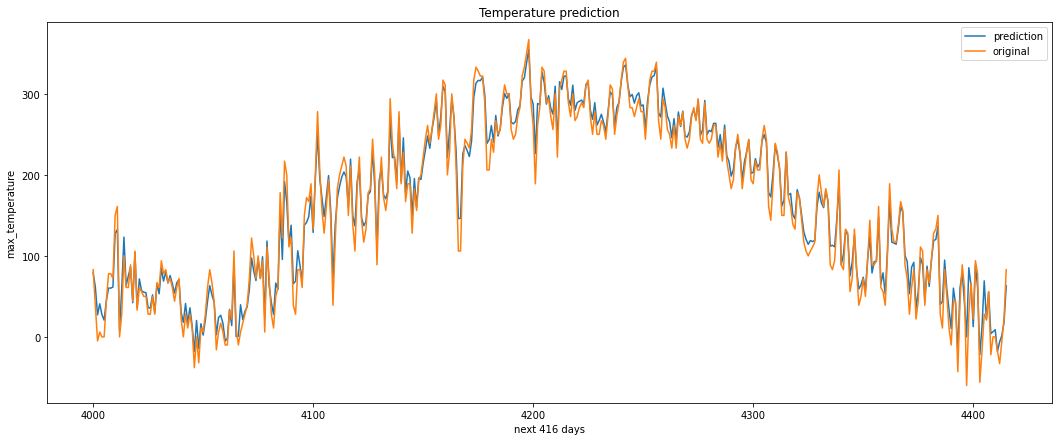

In [33]:
forecast_series = series[splitter-window_size+1:]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()

plt.figure(figsize=(18,7))
plt.title('Temperature prediction')
plt.xlabel(f'next {y_test.shape[0]} days')
plt.ylabel('max_temperature');
plt.plot(y_test,results,label='prediction')
plt.plot(y_test,X_test,label='original')
plt.legend();